### Model Training

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.ensemble.forest import RandomForestRegressor
from xgboost import XGBRFRegressor
from xgboost import XGBRegressor
import copy

In [2]:
def preprocess_data(file_name, train_ratio):
    df = pd.read_csv(file_name).values
    size = int(len(df)*train_ratio)

    X_train = df[:size,1:-1]
    X_test = df[size:,1:-1]
    y_train = df[:size,-1]
    y_test = df[size:,-1]
    dates = df[:,0]
    return [X_train, X_test, y_train, y_test, dates]

In [3]:
def predict(file_name, train_ratio, model_num=1):
    X_train, X_test, y_train, y_test, dates = preprocess_data(file_name, train_ratio)
    labels = y_train
    features = X_train
    if model_num == 1:
        model = XGBRFRegressor()
    elif model_num == 2:
        model = XGBRegressor()
    elif model_num == 3:
        model = RandomForestRegressor()
    else:
        raise ValueError('invalid model number. select model number from 1-3')

    
    rfr = model.fit(features, labels)
    X_train_predict=rfr.predict(X_train)
    X_test_predict=rfr.predict(X_test)
    return [X_train_predict, X_test_predict, y_train, y_test, dates]

In [4]:
def plot_results(predict_set,train_ratio, interval=60):
    X_train_predict,X_test_predict,y_train,y_test,dates = predict_set
    
    plt.plot(np.concatenate((y_train,y_test)))
    plt.plot(np.concatenate((X_train_predict,X_test_predict)))
    
    x = np.linspace(0,len(dates)-1,int(len(dates)/interval))
    plt.xticks(x,dates[0::interval])
    plt.axvspan(0, len(dates)*train_ratio, alpha=0.5, color='grey')
    
    plt.legend(['Truth','Prediction'])
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.title('Prediction and ground truth over specified time frame')
    return plt

In [5]:
def test_error(predict_set):
    _,X_test_predict,_,y_test,_ = predict_set
    return np.mean(abs(y_test-X_test_predict)/y_test)

In [35]:
def get_model(predict_horizon, model_type):
    if predict_horizon == 10:
        try:
            return  load('rf_regressor.joblib')
        except FileNotFoundError:
            print('Model cannot be located')
            return

In [6]:
file_name = 'ROKU.csv'
train_ratio = 0.8

test_error_vals = []

[14:36:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


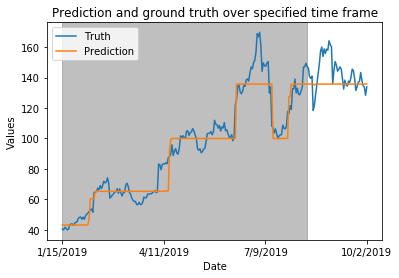

In [7]:
predict_set = predict(file_name, train_ratio, 1)
plot_results(predict_set, train_ratio)
test_error_vals.append(test_error(predict_set))

[14:36:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


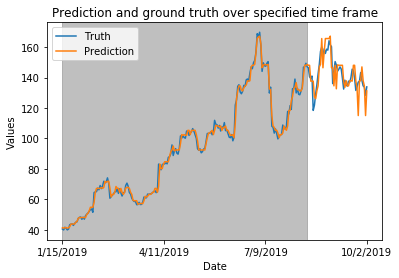

In [8]:
predict_set = predict(file_name, train_ratio, 2)
plot_results(predict_set, train_ratio)
test_error_vals.append(test_error(predict_set))

C:\Users\mdasa\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


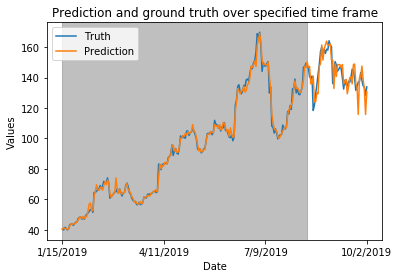

In [9]:
predict_set = predict(file_name, train_ratio, 3)
plot_results(predict_set, train_ratio)
test_error_vals.append(test_error(predict_set))

Text(0,0.5,'Normalized Absolute Error')

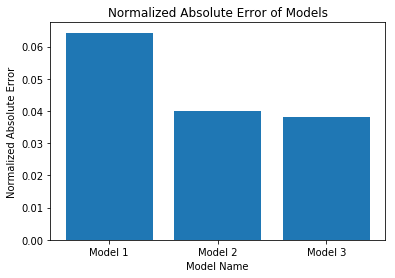

In [10]:
plt.bar(['Model 1', 'Model 2', 'Model 3'],test_error_vals)
plt.title('Normalized Absolute Error of Models')
plt.xlabel('Model Name')
plt.ylabel('Normalized Absolute Error')

## Model Inferencing

In [45]:
import pandas as pd
from joblib import dump, load
import numpy as np
import matplotlib.pyplot as plt

def inference(file_name, predict_horizon):
    try:
        df = pd.read_csv(file_name)
    except FileNotFoundError:
        print('File not found')
        return
    
    X_vals = np.array(df.iloc[:,-1]).reshape(-1,1)
    
    rfr = get_model(predict_horizon, 'rfr')
    y_hat = rfr.predict(X_vals)
    
    padding = predict_horizon*[0]
    output = np.concatenate((padding, y_hat))
    
    return output

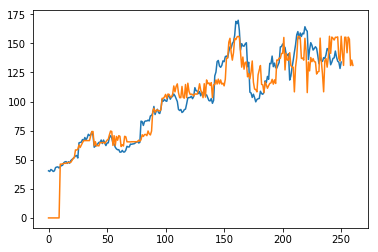

In [46]:
file_name = 'roku_stock.csv'
predict_horizon = 10

roku_df = pd.read_csv(file_name)
close = roku_df['Close'].values
output = inference(file_name, predict_horizon)

x1 = np.linspace(0,len(close)-1,len(close))
x2 = np.linspace(0,len(output)-1,len(output))
plt.plot(x1,close)
plt.plot(x2,output)
plt.show()

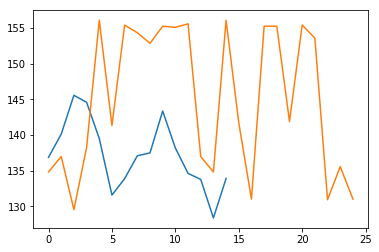

In [47]:
x1 = np.linspace(0,14,15)
x2 = np.linspace(0,24,25)
plt.plot(x1,close[-15:])
plt.plot(x2,output[-25:])
plt.show()